## Logistic regression and neural network

- [Data processing](#data-processing)
- [Logistic regression](#logistic-regression)
    - [Training](#logistic-regression-training)
    - [Training and validation loss](#training-vs-validation-loss-logistic-regression)
    - [Evaluation](#logistic-regression-evaluation)
- [Neural network](#neural-network)
    - [Training](#neural-network-training)
    - [Training and validation loss](#training-vs-valid-loss-neural-network)
    - [Evaluation](#neural-network-evaluation)

## Data processing

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt  

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler 
from sklearn import metrics  
import seaborn as sns

def train_validate_test_split(df, train_percent=.6, validate_percent=.2, seed=None):
    np.random.seed(seed) 
    perm         = np.random.permutation(df.index)
    m            = len(df.index) 
    train_end    = int(np.floor(int(train_percent * m)))
    validate_end = int(np.floor(int(validate_percent * m) + train_end)) 
    
    train        = df.iloc[perm[:train_end]]
    validate     = df.iloc[perm[train_end:validate_end]]
    test         = df.iloc[perm[validate_end:]] 
 

    train       = train.reset_index(drop=True)
    validate    = validate.reset_index(drop=True)
    test        = test.reset_index(drop=True)
    
    return train, validate, test

### Data spliting and loading

In [2]:
foldername = "archive" 
df = pd.read_csv('%s/Student Depression Dataset.csv' % foldername)   
df.keys()

Index(['id', 'Gender', 'Age', 'City', 'Profession', 'Academic Pressure',
       'Work Pressure', 'CGPA', 'Study Satisfaction', 'Job Satisfaction',
       'Sleep Duration', 'Dietary Habits', 'Degree',
       'Have you ever had suicidal thoughts ?', 'Work/Study Hours',
       'Financial Stress', 'Family History of Mental Illness', 'Depression'],
      dtype='object')

In [3]:
target_column = ['Depression']
feat_column   = [ 'Gender', 'Age', 'City', 'Profession', 'Academic Pressure', 'Work Pressure', 'CGPA', 'Study Satisfaction', 'Job Satisfaction',
       'Sleep Duration', 'Dietary Habits', 'Degree', 'Have you ever had suicidal thoughts ?', 'Work/Study Hours',
       'Financial Stress', 'Family History of Mental Illness'] 

In [4]:
all_column =  target_column + feat_column
df = df[all_column]
df = df.apply(LabelEncoder().fit_transform)


train_df, test_df, valid_df = train_validate_test_split(df, train_percent=.8, validate_percent=.1, seed=None)

X_scaler = StandardScaler() 
train_df[feat_column].values[:]        = X_scaler.fit_transform(train_df[feat_column].values[:] )
test_df[feat_column].values[:]         = X_scaler.transform(test_df[feat_column].values[:] )
valid_df[feat_column].values[:]        = X_scaler.transform(valid_df[feat_column].values[:] )

print("# Training   dataset: %d" % len(train_df))
print("# Testing    dataset: %d" % len(test_df))
print("# Validating dataset: %d" % len(valid_df))

# Training   dataset: 22320
# Testing    dataset: 2790
# Validating dataset: 2791


In [5]:
all_column = target_column + feat_column
train_enc = train_df[all_column]

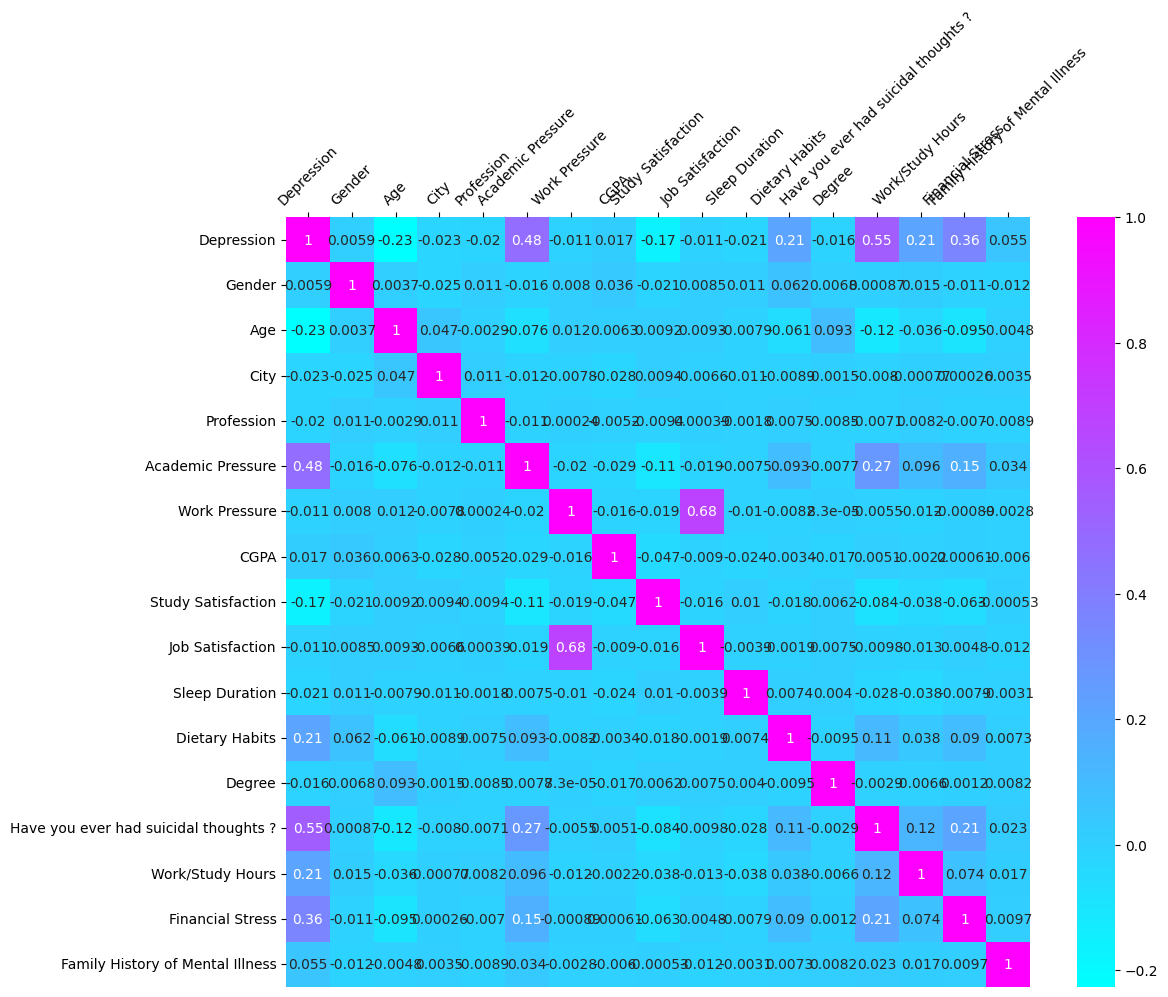

In [6]:
plt.figure(figsize=(12,10))
cor = train_enc.corr()
g = sns.heatmap(cor, annot=True, cmap=plt.cm.cool) 
g.axes.xaxis.set_ticks_position("top")
plt.setp(g.axes.get_xticklabels(), rotation=45)
plt.show()

## Data loader

In [7]:
import torch.nn as nn
import torch
from torch.utils.data import Dataset, DataLoader
 

class DataFrameDataset(Dataset):
    def __init__(self, df, features, target):
        self.df = df
        self.features = features
        self.target = target

        print("[Target = 1]: %d [Target = 0]: %d" % (len(df[target_column][(df[target_column].values == 1)]), len(df[target_column][(df[target_column].values == 0)])))

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        x = torch.tensor(row[self.features].values).to(torch.float)
        y = torch.tensor(row[self.target].values).to(torch.float)
        return x, y
 
print("Num feat. column = %d" % len(feat_column))
train_set = DataFrameDataset(train_df, features=feat_column, target=target_column)
valid_set = DataFrameDataset(valid_df, features=feat_column, target=target_column)
test_set  = DataFrameDataset(test_df, features=feat_column, target=target_column)


Num feat. column = 16
[Target = 1]: 13047 [Target = 0]: 9273
[Target = 1]: 1651 [Target = 0]: 1140
[Target = 1]: 1638 [Target = 0]: 1152


## Neural network and training

In [8]:
from tqdm import tqdm
import torch.optim as optim 
from torchmetrics.classification import BinaryF1Score
import os

model_name = "NeuralNet"


class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.ep      = 0
        self.min_validation_loss = float('inf')
        self.weight  = torch.empty((1,1), dtype=torch.int64)

    def check(self, weight, ep, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
            self.weight = weight
            self.ep     = ep
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False



class NeuralNetwork(nn.Module):    
    # build the constructor
    def __init__(self, n_inputs, n_outputs=1, n_hidden=1, num_layers=1, learning_rate=0.001, max_epoch=1000, model_folder=model_name, patience=1):
        super(NeuralNetwork, self).__init__()
         
        if num_layers == 1:
 
            model_list = [] 
            model_list.append(nn.Linear(n_inputs, n_outputs)) 
            model_list.append(nn.Sigmoid()) 
            self.model = nn.Sequential(*model_list)

        elif num_layers == 2:

            model_list = [] 
            model_list.append(nn.Linear(n_inputs, n_hidden))  
            model_list.append(nn.Linear(n_hidden, n_outputs))
            model_list.append(nn.Sigmoid())

            self.model = nn.Sequential(*model_list)

        else:

            model_list = [] 
            model_list.append(nn.Linear(n_inputs, n_hidden)) 
            for i in range(num_layers-2):
                model_list.append(nn.Linear(n_hidden, n_hidden))  
            model_list.append(nn.Linear(n_hidden, n_outputs))
            model_list.append(nn.Sigmoid())
            self.model = nn.Sequential(*model_list) 


        self.max_epoch       = max_epoch
        self.criterion       = nn.BCELoss()
        self.F1_score        = BinaryF1Score() 
        self.optimizer       = optim.Adam(self.model.parameters(), lr=learning_rate)  

        self.model_folder    = model_folder 
        os.makedirs(self.model_folder, exist_ok=True)

        self.Earlystoper    = EarlyStopper(patience=patience)
            
    def forward(self, x): 
        y_pred   = self.model(x)   
        return y_pred
    
    def train(self, train_set, valid_set, threshold, batch_size):
        
        training_avg_bce_list = []
        training_avg_f1_list = []

        valid_avg_bce_list = []
        valid_avg_f1_list = []


        validloader    = DataLoader(valid_set, batch_size=batch_size, shuffle=False, drop_last=True)

        for epoch in range(self.max_epoch):  # loop over the dataset multiple times

            trainloader = DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True)
            pbar        = tqdm(trainloader)

            self.model.train()
            mode = "TRAIN"
            loss_list     = [] 
            f1_score_list = [] 
            
            for data in pbar:
                # get the inputs; data is a list of [inputs, labels]
                inputs, labels = data 

                # zero the parameter gradients
                self.optimizer.zero_grad()

                # forward + backward + optimize
                predictions = self.model(inputs)

                loss = self.criterion(predictions, labels)
                loss.backward()
                self.optimizer.step()

                loss_list.append(loss.item())

                pred_binary = 1*(predictions  > threshold)

                f1_score = self.F1_score(pred_binary, labels)   
                f1_score_list.append(f1_score.item())
        
                pbar.set_description('%d [%s : %s] BIC Loss %0.3f, F1 score %0.3f' % (epoch, mode, model_name, sum(loss_list)/len(loss_list), sum(f1_score_list)/len(f1_score_list)))


            loss_list     = [] 
            f1_score_list = [] 
            mode = "VALID"
            self.model.eval()
            vpbar = tqdm(validloader)
            for i, data in enumerate(vpbar):
                inputs, labels = data

                with torch.no_grad():
                    predictions = self.model(inputs)

                loss = self.criterion(predictions, labels)
                loss_list.append(loss.item()) 

                pred_binary = 1*(predictions  >= threshold)

                f1_score = self.F1_score(pred_binary, labels)   
                f1_score_list.append(f1_score.item()) 

                vpbar.set_description('%d [%s : %s] BIC Loss %0.3f, F1 score %0.3f' % (epoch, mode, model_name, sum(loss_list)/len(loss_list), sum(f1_score_list)/len(f1_score_list)))


            training_avg_bce_list.append(sum(loss_list)/len(loss_list))
            training_avg_f1_list.append(sum(f1_score_list)/len(f1_score_list))
            valid_avg_bce_list.append(sum(loss_list)/len(loss_list))
            valid_avg_f1_list.append(sum(f1_score_list)/len(f1_score_list))
        
            stopping_criterion_met = self.Earlystoper.check(self.model.state_dict(), epoch, sum(loss_list)/len(loss_list))
        

            if stopping_criterion_met:   
                torch.save(self.model.state_dict(), '%s/%s.pth' % (self.model_folder, model_name))
                break  
        
        best_ep = self.Earlystoper
        return training_avg_bce_list, training_avg_f1_list, valid_avg_bce_list, valid_avg_f1_list, best_ep

In [9]:
from tqdm import tqdm
import os

n_hidden = 16
num_layers = 2

n_inputs      = len(feat_column) 
learning_rate = 0.0001
batch_size    = 256 
max_epoch     = 100
model_folder  = "NeuralNetwork-weights"

threshold     = 0.5
patience      = 1
 
neuralnet_model = NeuralNetwork(n_inputs, n_outputs=1, n_hidden=n_hidden, num_layers=num_layers, learning_rate=learning_rate, max_epoch=max_epoch, model_folder=model_folder, patience=patience)   
training_avg_bce_list, training_avg_f1_list, valid_avg_bce_list, valid_avg_f1_list, best_ep = neuralnet_model.train(train_set, valid_set, threshold, batch_size)

0 [TRAIN : NeuralNet] BIC Loss 8.761, F1 score 0.672: 100%|██████████| 87/87 [00:05<00:00, 14.82it/s] 
0 [VALID : NeuralNet] BIC Loss 2.200, F1 score 0.629: 100%|██████████| 10/10 [00:00<00:00, 15.68it/s]
1 [TRAIN : NeuralNet] BIC Loss 1.811, F1 score 0.561: 100%|██████████| 87/87 [00:05<00:00, 15.50it/s]
1 [VALID : NeuralNet] BIC Loss 1.416, F1 score 0.551: 100%|██████████| 10/10 [00:00<00:00, 15.53it/s]
2 [TRAIN : NeuralNet] BIC Loss 1.241, F1 score 0.539: 100%|██████████| 87/87 [00:05<00:00, 14.83it/s]
2 [VALID : NeuralNet] BIC Loss 0.998, F1 score 0.577: 100%|██████████| 10/10 [00:00<00:00, 15.48it/s]
3 [TRAIN : NeuralNet] BIC Loss 0.894, F1 score 0.575: 100%|██████████| 87/87 [00:05<00:00, 14.66it/s]
3 [VALID : NeuralNet] BIC Loss 0.758, F1 score 0.627: 100%|██████████| 10/10 [00:00<00:00, 15.43it/s]
4 [TRAIN : NeuralNet] BIC Loss 0.723, F1 score 0.635: 100%|██████████| 87/87 [00:05<00:00, 14.55it/s]
4 [VALID : NeuralNet] BIC Loss 0.667, F1 score 0.687: 100%|██████████| 10/10 [00:

### Training vs validation loss

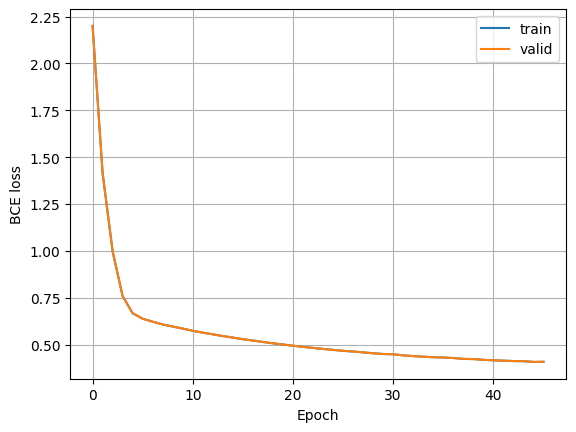

In [10]:
import matplotlib.pyplot as plt

x_value = range(len(training_avg_bce_list))
plt.plot(x_value, training_avg_bce_list, label="train")
plt.plot(x_value, valid_avg_bce_list, label="valid")
plt.ylabel("BCE loss")
plt.xlabel("Epoch")
plt.legend()
plt.grid()
plt.show()

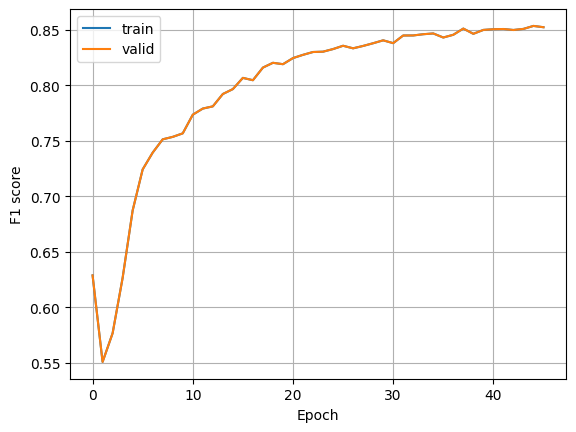

In [11]:
x_value = range(len(training_avg_bce_list))
plt.plot(x_value, training_avg_f1_list, label="train")
plt.plot(x_value, valid_avg_f1_list, label="valid")
plt.ylabel("F1 score")
plt.xlabel("Epoch")
plt.legend()
plt.grid()
plt.show()

### Evaluation

In [15]:
mode = "TEST"
neuralnet_model.model.eval()

criterion = nn.BCELoss()
F1_score  = BinaryF1Score() 

loss_list = []
f1_score_list = []

testloader     = DataLoader(test_set, batch_size=batch_size, shuffle=False, drop_last=True)
tpbar = tqdm(testloader)
for i, data in enumerate(tpbar):
    input_images, labels = data

    with torch.no_grad():
        predictions = neuralnet_model.model(input_images.view(batch_size,-1))

    loss = criterion(predictions, labels)  
    loss_list.append(loss.item()) 

    f1_score = F1_score(predictions, labels)  
    f1_score_list.append(f1_score.item()) 

    tpbar.set_description('[%s : %s] BIC Loss %0.3f, F1 score %0.3f' % (mode, model_name, sum(loss_list)/len(loss_list), sum(f1_score_list)/len(f1_score_list)))

[TEST : NeuralNet] BIC Loss 0.401, F1 score 0.857: 100%|██████████| 10/10 [00:00<00:00, 15.29it/s]
